In [73]:
#!/Users/soraward/opt/miniconda3/bin/python3 
data_root = "../data/"
# ML stuff
import numpy as np
from numpy.fft import *
import torch
from sklearn.linear_model import Lasso
import pandas as pd


from PIL import Image
# plotting
import matplotlib.pyplot as plt
import seaborn as sns



# basic stuff
import datetime
import requests
import io
from collections import Counter


from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf


In [179]:
# set index as datetime
def date_index_nasdaq(nasdaq):
    nasdaq_c = nasdaq.copy()
    dates = pd.to_datetime(nasdaq_c.Date)
    nasdaq_c.set_index(dates, inplace=True)
    # set date as index
    nasdaq_c.drop("Date", axis=1, inplace=True)
    nasdaq_c = nasdaq_c["2012-05-18":]
    return nasdaq_c

# for prepare_stock
def date_range_df(start, end, column_name = "Time"):
    date_range = pd.date_range(start, end)
    df = pd.DataFrame(date_range, columns = [column_name])
    df.set_index(column_name, inplace=True)
    return df

# merging with date range df
def prepare_stock(nasdaq, start, end, stock_name="AAPL", drop=True):
    nasdaq = nasdaq.loc[nasdaq["Name"]==stock_name]
    dates = date_range_df(start, end)
    new_nasdaq = dates.merge(nasdaq, how="left", left_index=True, right_index=True)
    if drop:
        new_nasdaq.dropna(inplace=True)
    return new_nasdaq

# create features volatility, volume, adj close
def get_features(nasdaq):
    #rename Adj Close
    nasdaq.rename(columns={"Adj Close":"Adj_Close"}, inplace=True)
    nasdaq["log_Volatility"] = np.log(nasdaq.High - nasdaq.Low + 1)
    nasdaq["log_Volume"] = np.log(nasdaq.Volume + 1) 
    nasdaq["log_Adj_Close"] = np.log(nasdaq["Adj_Close"] + 1)
    # nasdaq["log_Adj_Close_diff"] = nasdaq["log_Adj_Close"].diff()
    nasdaq.drop(columns = ["Low", "High", "Close", "Open", "Name", "Volume"], inplace=True)
    # nasdaq.dropna(inplace = True)
    return nasdaq

# this will return feature engineered stock dataframe
def get_stock(nasdaq, stock_name="AAPL"):
    nasdaq_c = date_index_nasdaq(nasdaq)
    stock = prepare_stock(nasdaq_c, nasdaq_c.index[0], nasdaq_c.index[-1], stock_name)
    stock = get_features(stock)
    stock.fillna("ffill", inplace=True)
    return stock

# plot heatmap for top stocks
def plot_attribute(nasdaq, using,feature="log_Adj_Close"):
    stocks = pd.DataFrame()
    for name in using:
        stocks[name] = get_stock(nasdaq, name)[feature]
    stocks.dropna(inplace=True)
    stocks.plot()
    plt.show()

# for fft
# signal has to be type pd.Series
def filter_signal(signal:pd.Series, threshhold=1e8):
    fourier = rfft(signal)
    freqs = rfftfreq(signal.size, d=20e-3/signal.size)
    fourier[freqs > threshhold] = 0
    return irfft(fourier)


# plot filtered signal with original
def plot_filtered(nasdaq:pd.DataFrame, stock_name="AAPL",stock_feature="log_Volume", threshhold=2e3, diff=False):
    if diff:
        stock_signal = pd.Series(get_stock(nasdaq, stock_name)[stock_feature]).diff()[1:]
    else:
        stock_signal = pd.Series(get_stock(nasdaq, stock_name)[stock_feature])

    if len(stock_signal)%2 == 1:
        stock_signal = stock_signal[:-1]
        assert(len(stock_signal) %2 ==0)
    filtered = pd.Series(filter_signal(stock_signal, threshhold))

    filtered.index = stock_signal.index 

    plt.figure(figsize=(13, 8))
    plt.title("_".join([stock_name, stock_feature]))
    plt.plot(stock_signal, label="Raw")
    plt.plot(filtered, label="Filtered")
    plt.legend()
    plt.grid(axis="x")
    plt.show()

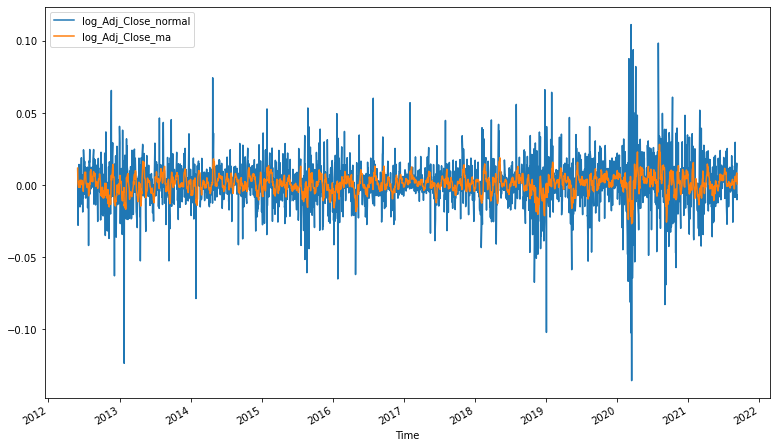

/Users/soraward/miniforge3/envs/pyflux/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


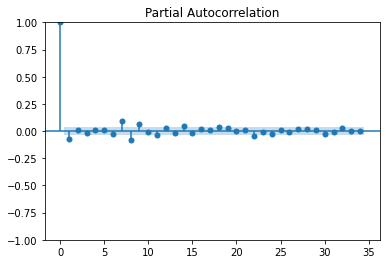

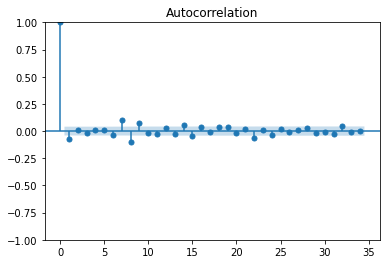

In [238]:
# plotting functions and shit
def plot_feature_coef(nasdaq, stock_name="AAPL"):
    aapl = get_stock(nasdaq, stock_name)
    corr = np.corrcoef(aapl.T)
    sns.heatmap(corr, xticklabels=aapl.columns, yticklabels=aapl.columns, annot=True)

# for some reason, the acf and pacf are not plotting well(they are the same)
def plot_acf_pacf(nasdaq, stock_name="AAPL"):
    aapl = get_stock(nasdaq, stock_name)
    signal = aapl["log_Adj_Close"].diff().dropna()[:-1]
    # filtered_aapl = filter_signal(signal,threshhold=2e4)
    ma = signal.rolling(7).mean().dropna()

    ma_aapl = pd.DataFrame(ma).merge(signal, "inner", left_index=True, right_index=True, suffixes=["_ma", "_normal"]).dropna()
    ma_aapl = ma_aapl[["log_Adj_Close_normal", "log_Adj_Close_ma"]]
    ma_aapl.plot(figsize=(13,8))
    plt.show()
    plot_pacf(signal)
    plot_acf(signal)
    plt.show()

In [100]:
# if __name__ == "__main__":
# read data
# for now, reading only unitl ebay
nasdaq = pd.read_csv(data_root + "NASDAQ_100_Data_From_2010.csv", sep="\t")
# stock lists
stock_list = ['AMGN','AAPL','MSFT','GOOG','AMZN','FB','TSLA','CTSH','JD','EBAY','AMD','SBUX','NVDA','ZM']
stock_list2 = ['CHKP','CHTR','CMCSA','COST','CPRT','CRWD','CSCO','CSX','CTAS','CTSH','DLTR','DOCU','DXCM','EA']
stock_list3 = ['EXC','FAST','FB','FISV','FOX','FOXA','GILD','GOOG','GOOGL','HON','IDXX','ILMN','INCY','INTC','INTU']
first_names = list(set([name for name in nasdaq.Name]))

# FB is from 2012-05-18, so we will use data from that point on
using = ["AAPL", "MSFT", "GOOGL", "AMZN", "TSLA", "FB", "NVDA"]#, "TSM", "UNH", "V"]

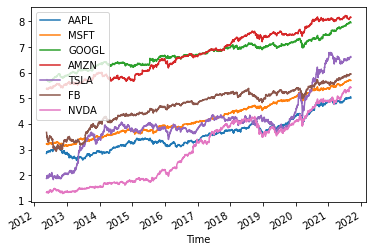

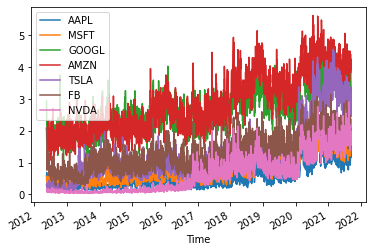

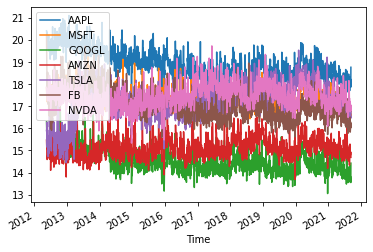

In [204]:
#特徴量プロット
plot_attribute(nasdaq, "log_Adj_Close")
plot_attribute(nasdaq, "log_Volatility")
plot_attribute(nasdaq, "log_Volume")

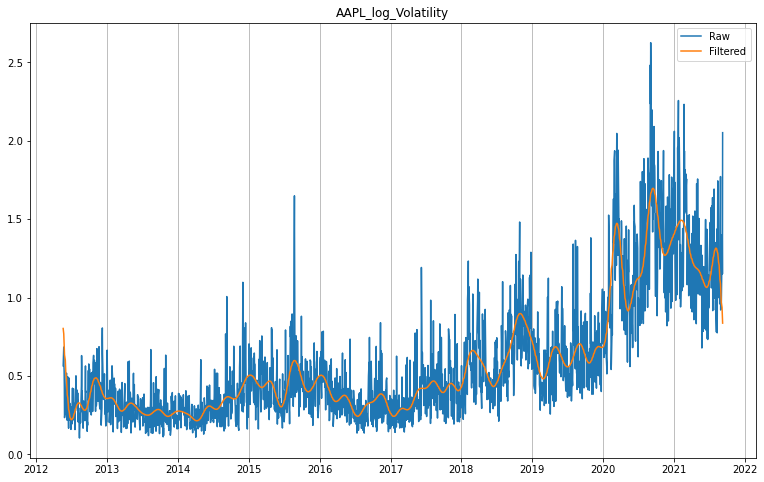

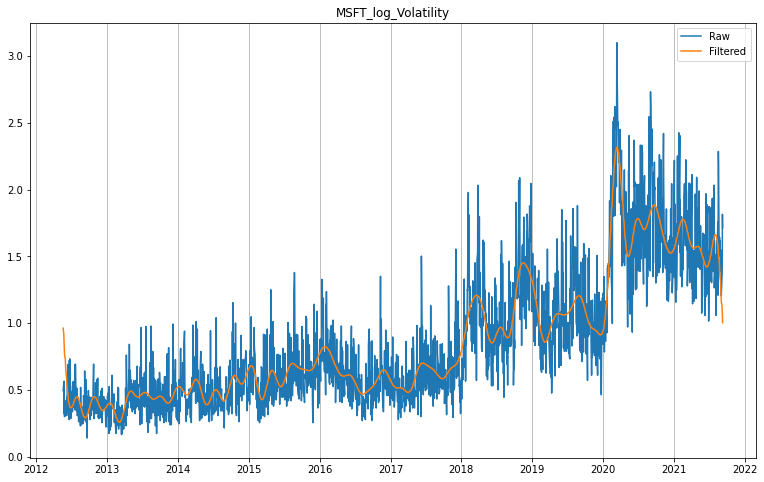

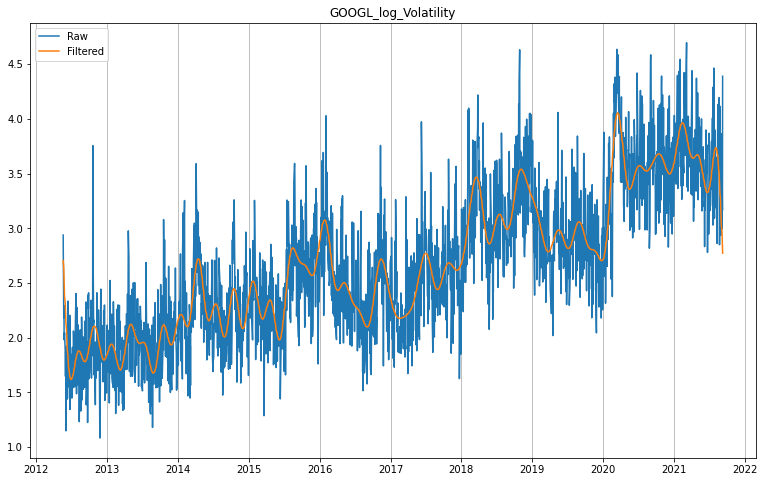

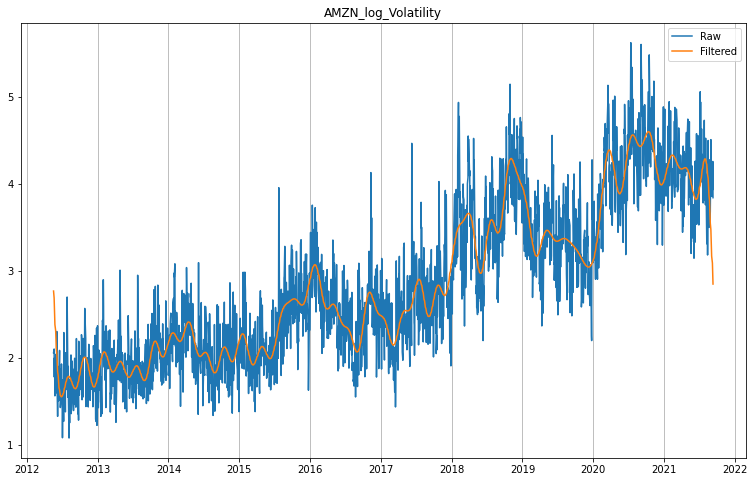

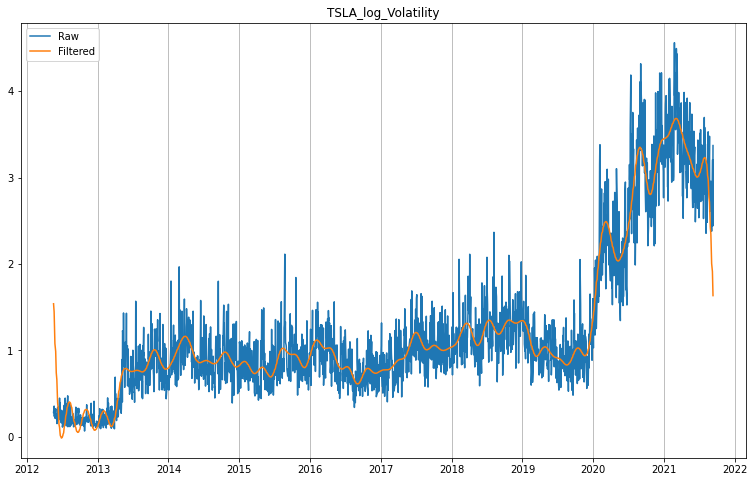

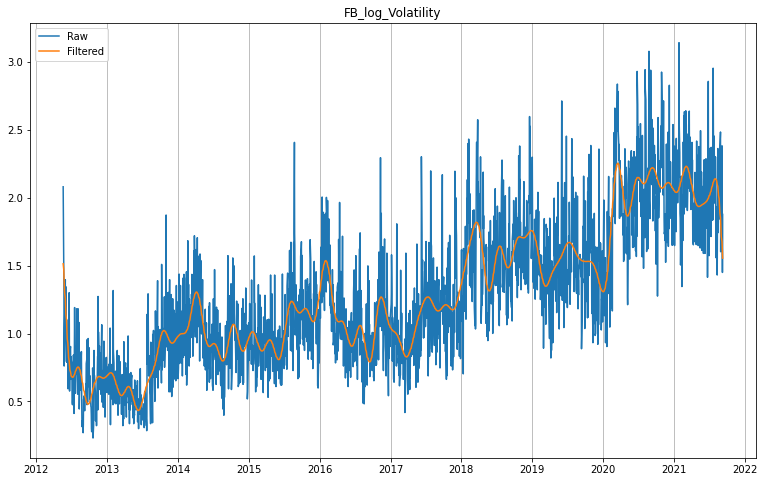

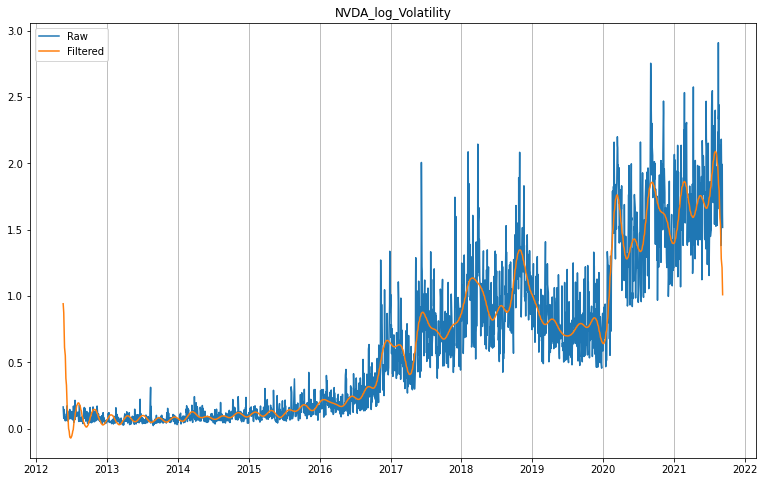

In [215]:
# plot per feature or per stock
features = ["log_Adj_Close", "log_Volume", "log_Volatility"]
plot_per_feature = False; plot_per_stock = True
if plot_per_feature:
    for feature in features:    
        plot_filtered(nasdaq, "AAPL", stock_feature=feature)
if plot_per_stock:
    for stock in using:
        plot_filtered(nasdaq, stock, stock_feature="log_Volatility")

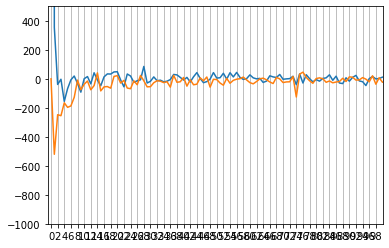

In [222]:
# get dominant frequency using fft
stock_signal = get_stock(nasdaq)["log_Volume"]
freq = rfft(stock_signal)
plt.plot(freq.real)
plt.plot(freq.imag)
x_end = 100
plt.xlim(-1, x_end)
plt.xticks(list(range(0, x_end, 2)))
plt.ylim(-1000, 500)
plt.grid(axis="x")